In [46]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import seaborn as sns
import tqdm

from modules import *
input_data = InputData("ANSPRACHE_MARKETING_IMPUTED", max_twin_num = 10, kernel_size = 1) #Options: ANSPRACHE, ANSPRACHE_MARKETING_IMPUTED

There are 1 NaN values in the data which are replaced with 0s.
There are 1 NaN values in the data which are replaced with 0s.
There are 1 NaN values in the data which are replaced with 0s.
There are 1 NaN values in the data which are replaced with 0s.
There are 1 NaN values in the data which are replaced with 0s.
There are 1 NaN values in the data which are replaced with 0s.
There are 1 NaN values in the data which are replaced with 0s.


In [2]:
# TODO: evaluieren der korrekten window positionen unter zero indexing, was sind die mindest dinger für die grid search windows, input dataen vollenden (z.B. NAs), die iid bootstraps implementieren
# alternativ den Mean Absolute Scaled Error und Symmetric Mean Absolute Percentage Error testen
#MASE: normieren des Fehlers mit mit mae eines naiven benchmarks

# FIXME: 

# NOTE: NA printout currently disabled for debugging, must be looked into later, evaluate why identical bounds from paper are not robust to all parameter combinations
#kann ich meine Ergebnisse eindeutiger machen, wenn ich mehr als 100 Testartikel nehme?
# Wie kann ich unterscheiden, ob der Fehler vom Model oder von den Twins kommt

#bias berechnung anders machen

# Window Size Analysis

[  0.   5.  13.  21.  29.  37.  45.  53.  61.  69.  77.  85.  93. 101.
 109. 117. 125. 133. 141. 149. 157. 165. 173. 181. 189. 197. 205. 213.
 221. 229. 237. 245. 253. 261. 269. 277. 285. 293. 301. 303.]
[  2.  10.  18.  26.  34.  42.  50.  58.  66.  74.  82.  90.  98. 106.
 114. 122. 130. 138. 146. 154. 162. 170. 178. 186. 194. 202. 210. 218.
 226. 234. 242. 250. 258. 266. 274. 282. 290. 298. 305. 305.]


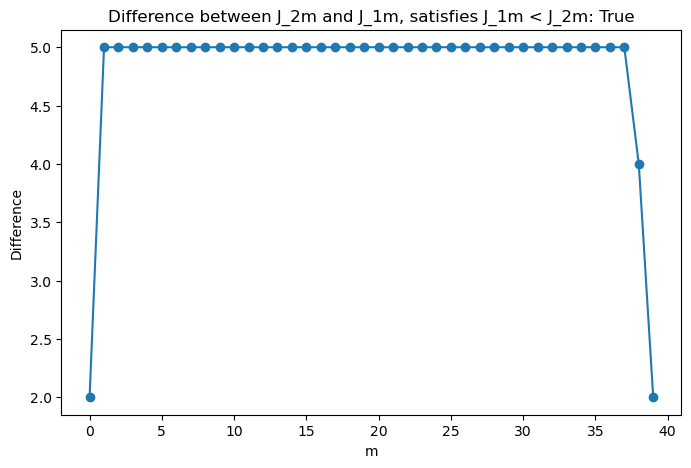

In [3]:
#sind meine windows centered oder asymmetrisch? -> den zenterpunkt +0.5 setzen
#window size dürfen nur gerade zahlen sein, sonst sind grenzen dezimalzahlen
#dadurch, dass der ub nicht inclusive ist, sind die intervalle nicht symmetrisch um den Index m*b
#was wäre eine Lösung? (abwägung zwischen symmetrischem, ungeraden intervall und asymmetrischem, geraden intervall)
#window size 1 hat die beste performance, dass müssen wir also eigentlich berücksichtigen
#-> wie verhalten sich die intervallgrenzen bei window size 1? mit den decimalzahlengrenzen
#-> vielleicht is es deshalb nicht viel besser als der standard bootstrap
N = 313
b = 8
w = 4
M = int(np.ceil(N / b))

# Compute J_1m and J_2m
J_1m_values = np.maximum(0, np.minimum(np.arange(M) * b - w/2-1, N-b - w/2))# Shape: (M,)
print(J_1m_values)
J_2m_values = np.maximum(0, np.minimum(np.arange(M) * b + w/2, N-b))    # Shape: (M,)
print(J_2m_values)

# Compute the difference
difference = J_2m_values - J_1m_values

# Plot the difference
plt.figure(figsize=(8, 5))
plt.plot(range(M), difference, marker='o', linestyle='-', label='J_2m - J_1m')
plt.xlabel('m')
plt.ylabel('Difference')
plt.title(f'Difference between J_2m and J_1m, satisfies J_1m < J_2m: {~np.any(J_1m_values >= J_2m_values)}')
plt.show()

# Empirical Test of Local Block Bootstrap

In [4]:
# input_validation = InputData("ANSPRACHE_MARKETING_IMPUTED", max_twin_num = 10, kernel_size = 15)
# input_validation.TwinData = input_validation.TestData

# Evaluation.run_grid(input_data, output_file="method_validation")

In [5]:
df_validation = pd.read_csv("results/method_validation.csv") #method_validation
df_validation.groupby(["WINDOW_SIZE", "BLOCK_SIZE"]).median().sort_values("WASSERSTEIN").reset_index().head(10) #median, bc distribution is skewed

,WINDOW_SIZE,BLOCK_SIZE,TEST_ITEM_COMMUNICATIONKEY,TWIN_NUMBER,MEAN_SAMPLE,MEAN_TEST,BIAS,RESAMPLING_VARIANCE,TARGET_VARIANCE,CV,RMSE,MAPE,MPE,MAE,WASSERSTEIN
0,0,1,851443376.0,6.5,403.939687,337.5,56.948031,3286.973297,7.300368e+05,0.132558,220.533214,0.616538,0.251817,210.132116,213.353621
1,13,1,851443376.0,6.5,404.100026,337.5,57.773689,2472.289038,7.031013e+05,0.118151,216.564327,0.614949,0.250510,209.066077,215.380785
2,5,1,851443376.0,6.5,403.291614,337.5,57.795734,2340.312242,7.086509e+05,0.114919,218.100838,0.610066,0.254887,210.899137,215.624753
3,9,1,851443376.0,6.5,404.440010,337.5,58.738711,2432.796768,7.035786e+05,0.116594,217.355853,0.606414,0.254018,210.339506,215.766049
4,57,7,851443376.0,6.5,407.309199,337.5,68.784894,12307.895764,1.143908e+06,0.237685,250.243462,0.656647,0.253254,219.448484,217.085097
5,33,1,851443376.0,6.5,406.794712,337.5,59.466356,2632.484146,6.851622e+05,0.119226,217.817285,0.620033,0.252013,211.890223,217.120773
6,17,1,851443376.0,6.5,403.194467,337.5,58.921058,2546.970155,7.053161e+05,0.118997,216.906758,0.613312,0.248587,210.036876,217.157387
7,1,1,851443376.0,6.5,402.586424,337.5,57.519657,2238.908276,7.105815e+05,0.111448,219.499892,0.613680,0.251833,212.876117,217.184372
8,21,1,851443376.0,6.5,404.626740,337.5,59.118228,2564.533283,7.010471e+05,0.118779,216.127913,0.619178,0.249895,210.288532,217.247533
9,41,1,851443376.0,6.5,406.352536,337.5,59.156723,2654.946453,6.907042e+05,0.120143,218.438686,0.623927,0.248699,205.977903,217.646442


# Parameter Tuning

In [ ]:
Evaluation.run_grid(input_data)
df_grid_results = pd.read_csv("results/grid_results.csv")
df_grid_results.groupby(["WINDOW_SIZE", "BLOCK_SIZE"]).median().drop(["TEST_ITEM_COMMUNICATIONKEY", "TWIN_NUMBER"], axis=1).sort_values("MAE").reset_index().head(20) #median, bc distribution is skewed

# Trends in Parameter Configuration

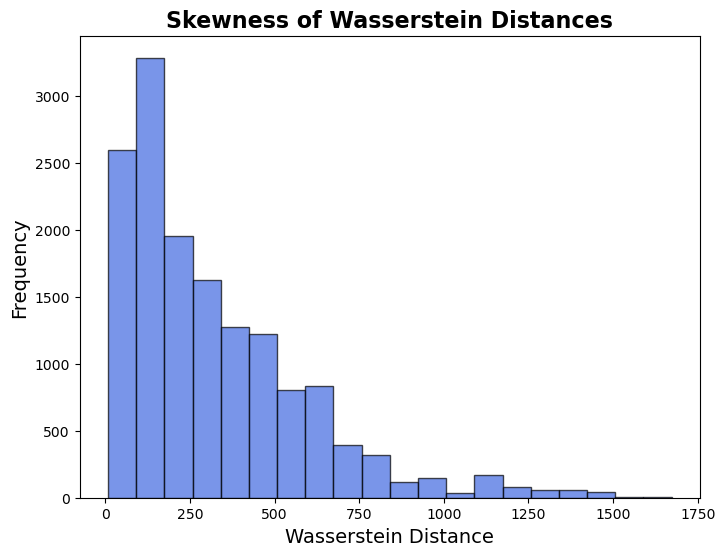

In [8]:
plt.figure(figsize=(8, 6))
plt.hist(df_grid_results.query("WINDOW_SIZE != 0")["WASSERSTEIN"], bins=20, color="royalblue", edgecolor="black", alpha=0.7)

# Labels and title
plt.xlabel("Wasserstein Distance", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Skewness of Wasserstein Distances", fontsize=16, fontweight="bold")

# Show the plot
plt.show()


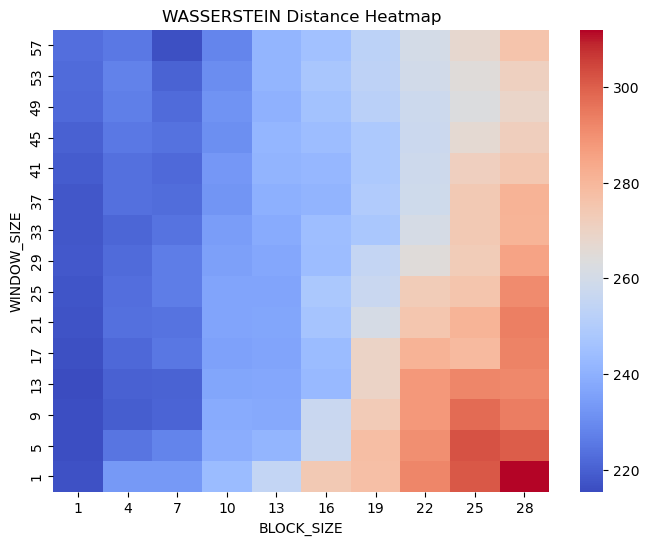

In [45]:
metric = "WASSERSTEIN"
df_heatmap = df_grid_results.query("WINDOW_SIZE != 0")\
    .groupby(["WINDOW_SIZE", "BLOCK_SIZE"]).median().reset_index()\
    .pivot(index="WINDOW_SIZE", columns="BLOCK_SIZE", values=metric).sort_index(ascending=False)

plt.figure(figsize=(8, 6))
sns.heatmap(df_heatmap.sort_index(ascending=False), cmap="coolwarm")#gray
plt.xlabel("BLOCK_SIZE")
plt.ylabel("WINDOW_SIZE")
plt.title(f"{metric} Distance Heatmap")
plt.show()

### Fazit
- im BIAS ist keine Struktur auf Grund verschiedener Parameter zu erkennen
- in der VARIANCE ist die Struktur deutlich
- Haupteinfluss in der Wasserstein Evaluierung ist die Varianz    
-> ist der Moving Bootstrap trotzdem noch besser, als der  IID Bootstrap (Vergleich von BIAS und Varianz)
- da wir BIAS und Variance als entscheidende Größen betrachten bewerten wir insgesamt mit der Wasserstein Metric, da sie sich decomposen lässt in BIAS und Variance Delta -> dafür muss normalität noch geprüft werden
- muss ich rechtfertigen, dass ich kein validation set habe?

# Best Local Parameters

In [10]:
#Idea to optimize the results by using subclusters in seperate python file
#Discarded as it seems to overengineer the problem in relation to the possible gain

input_data.TestData.keys()
df_grid_results.query("TEST_ITEM_COMMUNICATIONKEY == 807444058").sort_values("WASSERSTEIN")
#Order by Wasserstein
#Benchmark best: 716679764
#Random: 796628327, 803603891, 807444298, 811224241, 
#Moving Bootstrap best: 807443786

,TEST_ITEM_COMMUNICATIONKEY,BLOCK_SIZE,WINDOW_SIZE,TWIN_NUMBER,MEAN_SAMPLE,MEAN_TEST,BIAS,RESAMPLING_MEAN_TWIN,RESAMPLING_MEAN_TEST,RESAMPLING_VARIANCE_TWIN,RESAMPLING_VARIANCE_TEST,TARGET_VARIANCE,CV,RMSE,MAPE,MPE,MAE,WASSERSTEIN
1550,807444058,1,33,5,199.078766,246.0,-46.921234,199.078766,246.277002,604.291815,334.060163,70496.812153,0.123481,52.970690,0.193789,-0.190737,47.672014,47.625372
1545,807444058,1,29,5,198.187816,246.0,-47.812184,198.187816,245.590831,565.588695,337.810980,71645.238992,0.119998,53.400315,0.196469,-0.194358,48.331311,47.713657
2260,807444058,1,0,5,197.864936,246.0,-48.135064,197.864936,245.653454,630.048316,447.195687,74042.882471,0.126858,54.286580,0.198879,-0.195671,48.924337,47.964018
1530,807444058,1,17,5,198.188681,246.0,-47.811319,198.188681,246.324712,562.617110,317.507892,71568.512256,0.119682,53.371709,0.196492,-0.194355,48.337029,48.502380
1540,807444058,1,25,5,197.921693,246.0,-48.078307,197.921693,246.179855,585.817007,340.520352,72794.559217,0.122289,53.826951,0.197915,-0.195440,48.687113,48.601963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,807444058,28,13,5,196.327526,246.0,-49.672474,196.327526,248.751140,6729.143988,62.494118,231033.990875,0.417829,95.898377,0.329631,-0.201921,81.089200,90.835449
2110,807444058,25,1,5,196.824614,246.0,-49.175386,196.824614,247.916946,5940.793283,2.854766,209995.569457,0.391600,91.427632,0.313305,-0.199900,77.073052,91.113809
2195,807444058,28,9,5,198.572809,246.0,-47.427191,198.572809,249.514738,6865.128099,51.008808,228972.199624,0.417258,95.469715,0.327276,-0.192793,80.509979,91.298996
2190,807444058,28,5,5,199.727622,246.0,-46.272378,199.727622,249.458834,6838.378974,18.617434,225581.515035,0.414036,94.760287,0.326370,-0.188099,80.286957,92.850024


# Best Parameter Configuration vs. Benchmark

In [11]:
best_params = (1, 1)

results  = []
for test_item_key in input_data.TestData.keys():
    results.append(Evaluation.run_lbb(input_data.TwinData[test_item_key], input_data.TestData[test_item_key], test_item_key, *best_params))
    results.append(Evaluation.run_idd(input_data.TwinData[test_item_key], input_data.TestData[test_item_key], test_item_key))

df_results = pd.DataFrame(results)

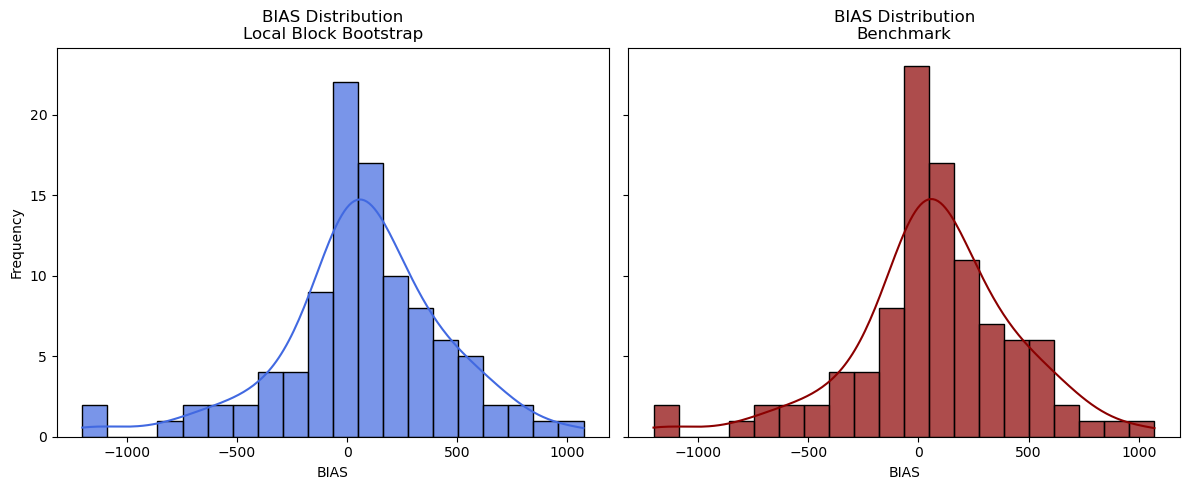

In [42]:
# Create side-by-side histograms with KDE
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# Best parameters plot
sns.histplot(df_results.query( f"BLOCK_SIZE == {best_params[1]} & WINDOW_SIZE == {best_params[0]}")["BIAS"], bins=20, kde=True, color="royalblue", edgecolor="black", ax=axes[0], alpha=0.7)
axes[0].set_title(f"BIAS Distribution\nLocal Block Bootstrap")
axes[0].set_xlabel("BIAS")
axes[0].set_ylabel("Frequency")

# Benchmark plot
sns.histplot(df_results.query("BLOCK_SIZE == 1 & WINDOW_SIZE == 0")["BIAS"], bins=20, kde=True, color="darkred", edgecolor="black", ax=axes[1], alpha=0.7)
axes[1].set_title("BIAS Distribution\nBenchmark")
axes[1].set_xlabel("BIAS")
axes[1].set_ylabel("")  # No duplicate ylabel

# Adjust layout
plt.tight_layout()
plt.show()

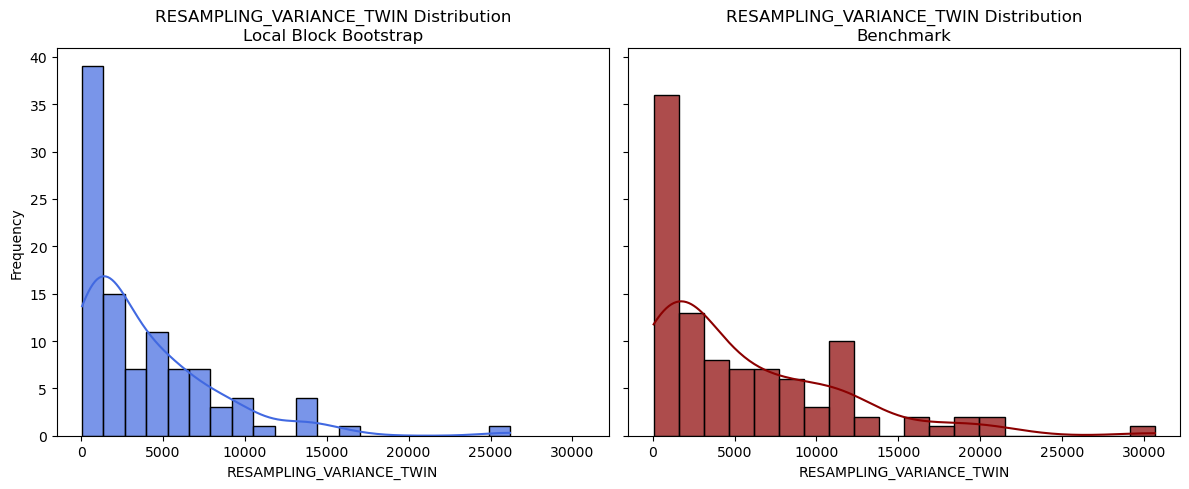

In [43]:
# Create side-by-side histograms with KDE
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# Best parameters plot
sns.histplot(df_results.query( f"BLOCK_SIZE == {best_params[1]} & WINDOW_SIZE == {best_params[0]}")["RESAMPLING_VARIANCE_TWIN"], bins=20, kde=True, color="royalblue", edgecolor="black", ax=axes[0], alpha=0.7)
axes[0].set_title(f"RESAMPLING_VARIANCE_TWIN Distribution\nLocal Block Bootstrap")
axes[0].set_xlabel("RESAMPLING_VARIANCE_TWIN")
axes[0].set_ylabel("Frequency")

# Benchmark plot
sns.histplot(df_results.query("BLOCK_SIZE == 1 & WINDOW_SIZE == 0")["RESAMPLING_VARIANCE_TWIN"], bins=20, kde=True, color="darkred", edgecolor="black", ax=axes[1], alpha=0.7)
axes[1].set_title("RESAMPLING_VARIANCE_TWIN Distribution\nBenchmark")
axes[1].set_xlabel("RESAMPLING_VARIANCE_TWIN")
axes[1].set_ylabel("")  # No duplicate ylabel

# Adjust layout
plt.tight_layout()
plt.show()

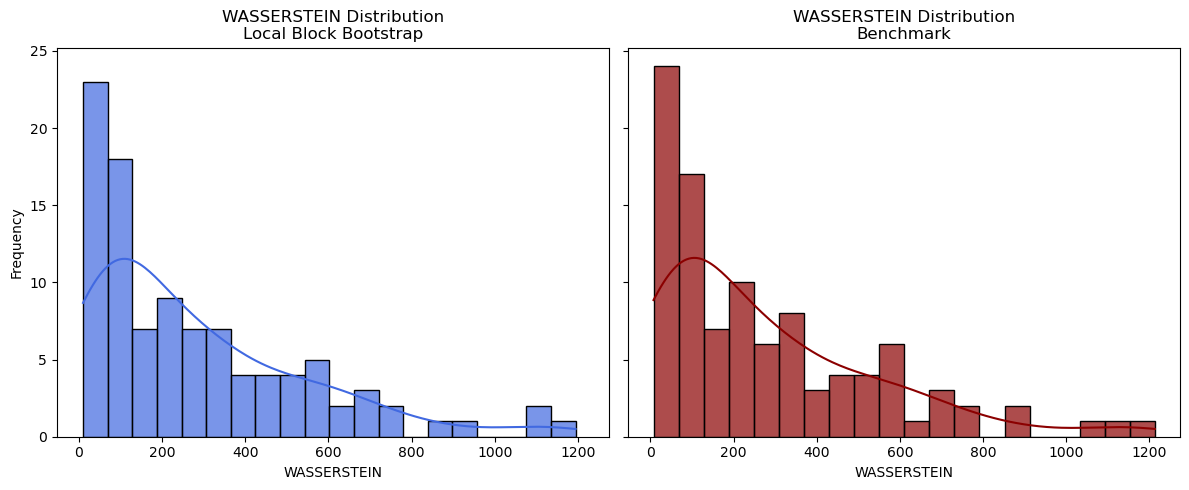

In [44]:
# Create side-by-side histograms with KDE
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# Best parameters plot
sns.histplot(df_results.query( f"BLOCK_SIZE == {best_params[1]} & WINDOW_SIZE == {best_params[0]}")["WASSERSTEIN"], bins=20, kde=True, color="royalblue", edgecolor="black", ax=axes[0], alpha=0.7)
axes[0].set_title(f"WASSERSTEIN Distribution\nLocal Block Bootstrap")
axes[0].set_xlabel("WASSERSTEIN")
axes[0].set_ylabel("Frequency")

# Benchmark plot
sns.histplot(df_results.query("BLOCK_SIZE == 1 & WINDOW_SIZE == 0")["WASSERSTEIN"], bins=20, kde=True, color="darkred", edgecolor="black", ax=axes[1], alpha=0.7)
axes[1].set_title("WASSERSTEIN Distribution\nBenchmark")
axes[1].set_xlabel("WASSERSTEIN")
axes[1].set_ylabel("")  # No duplicate ylabel

# Adjust layout
plt.tight_layout()
plt.show()

In [41]:
# Summary Statistics: Median
median_results = df_results.groupby(["WINDOW_SIZE", "BLOCK_SIZE"])[["BIAS", "RESAMPLING_VARIANCE_TWIN", "WASSERSTEIN"]].median().reset_index()

# Summary Statistics: Mean
mean_results = df_results.groupby(["WINDOW_SIZE", "BLOCK_SIZE"])[["BIAS", "RESAMPLING_VARIANCE_TWIN", "WASSERSTEIN"]].mean().reset_index()

# Display results
display("Median Results:", median_results)
display("Mean Results:", mean_results)


'Median Results:'

,WINDOW_SIZE,BLOCK_SIZE,BIAS,RESAMPLING_VARIANCE_TWIN,WASSERSTEIN
0,0,1,56.013209,3349.878474,213.086644
1,1,1,57.034417,2221.356094,215.988282


'Mean Results:'

,WINDOW_SIZE,BLOCK_SIZE,BIAS,RESAMPLING_VARIANCE_TWIN,WASSERSTEIN
0,0,1,69.751604,5582.280814,280.690058
1,1,1,70.963863,3943.097991,282.516806


Conclusion:
- bootstrap method mainly influences the variance
- lowest variance is achieved via Sequential Panel Sampling

# Optimal Twin Size
- Trade off: few twins means having only the most similar products but also increases chance to miss out on variation

In [ ]:
input_data_list = [InputData("ANSPRACHE_MARKETING_IMPUTED", max_twin_num = t, kernel_size = 1) for t in range(1, 11)]

results_twin_parameter  = []
for data in tqdm(input_data_list):
    for test_item_key in input_data.TestData.keys():
        results_twin_parameter.append(Evaluation.run_lbb(input_data.TwinData[test_item_key], input_data.TestData[test_item_key], test_item_key, *best_params))

df_results_twin_parameter = pd.DataFrame(results_twin_parameter)
df_results_twin_parameter.to_csv("results/twin_parameter_results.csv", index=False)

There are 1 NaN values in the data which are replaced with 0s.
There are 1 NaN values in the data which are replaced with 0s.
There are 1 NaN values in the data which are replaced with 0s.
There are 1 NaN values in the data which are replaced with 0s.
There are 1 NaN values in the data which are replaced with 0s.
There are 1 NaN values in the data which are replaced with 0s.
There are 1 NaN values in the data which are replaced with 0s.
There are 1 NaN values in the data which are replaced with 0s.
There are 1 NaN values in the data which are replaced with 0s.
There are 1 NaN values in the data which are replaced with 0s.
There are 1 NaN values in the data which are replaced with 0s.
There are 1 NaN values in the data which are replaced with 0s.
There are 1 NaN values in the data which are replaced with 0s.
There are 1 NaN values in the data which are replaced with 0s.
There are 1 NaN values in the data which are replaced with 0s.
There are 1 NaN values in the data which are replaced w

  0%|          | 0/10 [00:00<?, ?it/s]

In [48]:
df_results_twin_parameter

,TEST_ITEM_COMMUNICATIONKEY,BLOCK_SIZE,WINDOW_SIZE,TWIN_NUMBER,MEAN_SAMPLE,MEAN_TEST,BIAS,RESAMPLING_MEAN_TWIN,RESAMPLING_MEAN_TEST,RESAMPLING_VARIANCE_TWIN,RESAMPLING_VARIANCE_TEST,TARGET_VARIANCE,CV,RMSE,MAPE,MPE,MAE,WASSERSTEIN
0,716679764,1,1,9,672.842471,372.0,300.842471,672.842471,364.199512,9281.677500,234.677237,2.410290e+06,0.143186,315.892181,0.808716,0.808716,300.842471,319.106767
1,716679764,1,0,9,672.884066,372.0,300.884066,672.884066,370.913148,11476.351131,1365.291657,2.463896e+06,0.159207,319.386243,0.808937,0.808828,300.924610,310.021367
2,718909161,1,1,6,368.297924,426.0,-57.702076,368.297924,420.663837,2276.416667,313.872519,1.334641e+05,0.129547,74.872867,0.149568,-0.135451,63.716171,60.379933
3,718909161,1,0,6,368.537659,426.0,-57.462341,368.537659,424.937372,3049.423127,1376.315647,1.512079e+05,0.149840,79.695318,0.157394,-0.134888,67.050010,59.266616
4,735286989,1,1,7,581.218148,530.0,51.218148,581.218148,529.539813,2284.788710,424.850300,1.095453e+05,0.082240,70.057743,0.108697,0.096638,57.609309,58.405724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1617994924,1,0,10,450.011388,213.0,237.011388,450.011388,212.698504,3485.719576,502.949511,8.194975e+05,0.131197,244.254207,1.112730,1.112730,237.011388,240.131582
1996,1617995015,1,1,6,213.253931,69.0,144.253931,213.253931,69.451951,725.945457,28.010888,6.049156e+05,0.126344,146.748567,2.090637,2.090637,144.253931,145.424041
1997,1617995015,1,0,6,210.948888,69.0,141.948888,210.948888,69.227272,965.696606,159.494630,5.931177e+05,0.147314,145.310645,2.057230,2.057230,141.948888,142.917997
1998,1637109554,1,1,7,257.396676,173.0,84.396676,257.396676,171.048812,1088.374447,140.537388,2.073474e+05,0.128170,90.615525,0.488053,0.487842,84.433146,88.906729


# Error Analysis
- How can we deal with the slight bias in our result?
- Identifying and analysing outlier items -> 3 Error types: twins way to high, twins way to low, different seasonality curves

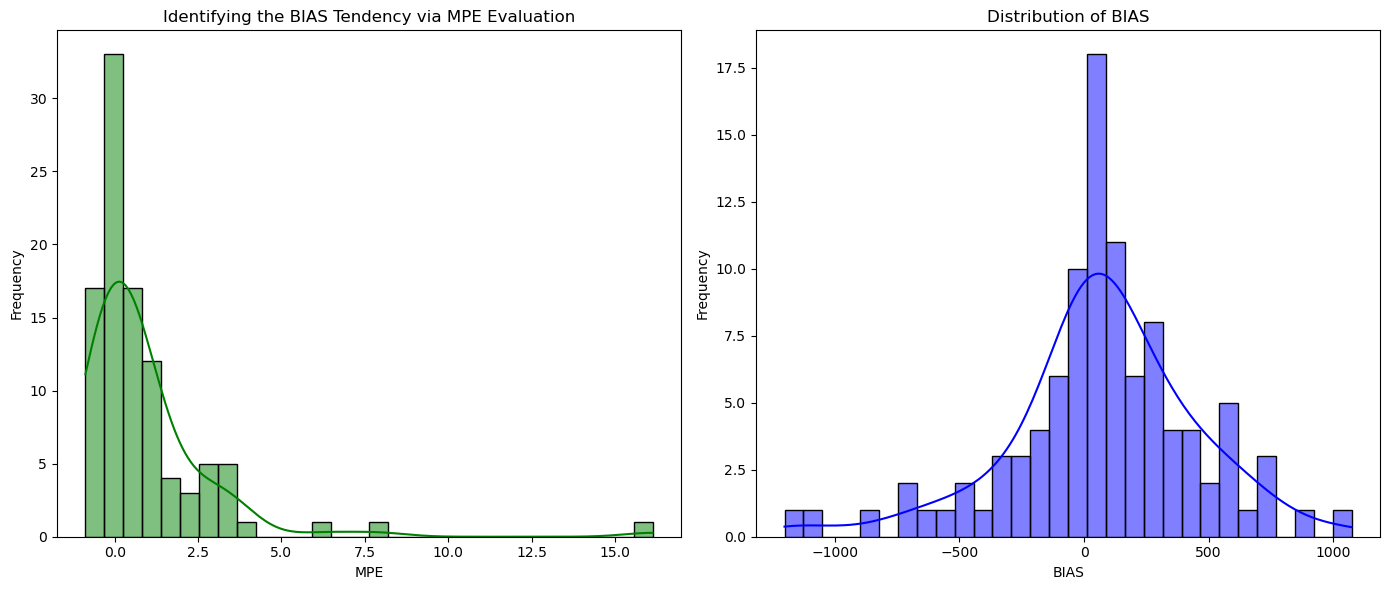

In [18]:
#note: mape is not symmetric!
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First subplot: LBB_MPE histogram
sns.histplot(df_results.query("WINDOW_SIZE != 0")["MPE"], bins=30, kde=True, color="green", ax=axes[0])
axes[0].set_xlabel("MPE")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Identifying the BIAS Tendency via MPE Evaluation")

# Second subplot: BIAS histogram
sns.histplot(df_results.query("WINDOW_SIZE != 0")["BIAS"], bins=30, kde=True, color="blue", ax=axes[1])
axes[1].set_xlabel("BIAS")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Distribution of BIAS")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()
#wenn man range kennt -> null sollte mitte des bins sein, oder bin genau an der grenze -> sich dynamisch ändern bei neuem input

In [19]:
df_grid_results.query("WINDOW_SIZE == 0").groupby("TEST_ITEM_COMMUNICATIONKEY").median().sort_values("MAPE", ascending=True).reset_index()[["TEST_ITEM_COMMUNICATIONKEY", "MAPE", "MPE"]].head(30)
#Hauptfehlerquellen:
# Twins haben deutlich höhere Ansprache als der Testartikel
# Saisonkurven passen nicht
# Twins haben deutlich niedrigere Ansprache als der Testartikel

,TEST_ITEM_COMMUNICATIONKEY,MAPE,MPE
0,850575936,0.077274,0.008840
1,1088115601,0.089959,0.059224
2,850562202,0.092344,-0.061165
3,811408901,0.092959,-0.072798
4,1594262232,0.093694,0.042784
5,1085391770,0.098006,-0.017042
6,868192553,0.114530,-0.060751
7,869458445,0.115983,0.095215
8,836346869,0.117048,0.068591
9,811405342,0.117295,0.092947


# Experiments

- Apply smoothing function on input time series, Idee: summer verändert sich nicht, risiko peaks zu samplen geht runter
-> ist vielleicht eine ganz glatte serie besser geeignet, um blöcke zu samplen -> dann ist der input weniger random
- Ansprache Marketing Imputed -> nahezu keine Auswirkung, dazu keine Verbesserung
- Influence of number of twins
- Change of observation period, change of product group
- Einfluss von NAs auf den Fehler -> quasi keine NAs mehr, wenn wir bei FirstSoldout strikt cutten
- Einfluss von Soldout auf den Fehler


# Normality test
- clt is defined for iid data
- distributions moments must be finite?
- tune number of iteration until distribution is normal -> helps simplify methods of robust optimization

In [20]:
samples = Resampling.lb_bootstrap(input_data.TestData[804245827], 14, 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the histogram
ax1.hist(samples, bins=50, density=True, alpha=0.6, color='grey', edgecolor='black', label='Bootstrap PDF')
ax1.set_title('Histogram of Bootstrapped Values')
ax1.set_xlabel('Value')
ax1.set_ylabel('Density')

# Remove top and right spines for the histogram
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Calculate the normal PDF
x = np.linspace(min(samples), max(samples), 100)
normal_pdf = stats.norm.pdf(x, loc=np.mean(samples), scale=np.sqrt(np.var(samples, ddof = 1)))

# Plot the normal PDF
ax1.plot(x, normal_pdf, label='Normal PDF', color='black', linestyle='-')

# Plot the empirical CDF
data_sorted = np.sort(samples)
# Calculate the ECDF values
ecdf = np.arange(1, len(data_sorted) + 1) / len(data_sorted)
ax2.plot(data_sorted, ecdf, marker='o', linestyle='none', color='grey', label='Bootstrap CDF')

# Remove top and right spines for the CDF
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Calculate the normal CDF
normal_cdf = stats.norm.cdf(x, loc=np.mean(samples), scale=np.sqrt(np.var(samples, ddof = 1)))

# Plot the normal CDF
ax2.plot(x, normal_cdf, label='Normal CDF', color='black', linestyle='-')

ax2.set_title('Empirical CDF vs Normal CDF')
ax2.set_xlabel('Value')
ax2.set_ylabel('Cumulative Probability')

# Add legends
ax1.legend()
ax2.legend()

plt.tight_layout()
plt.savefig('plots/bootstrap_joint_distribution.svg')
plt.show()


KeyError: 804245827

In [ ]:
#H0: the data is normally distributed
#define alpha level
alpha = 0.05

In [ ]:
#generate integer samples from normal distribution
norm_samples = np.random.normal(50, 25, 100000).astype(int)

In [ ]:
_, p_value = stats.normaltest(samples)
print(p_value)
if p_value > alpha:
    print("Fail to reject the null hypothesis: The data appears to be normally distributed.")
else:
    print("Reject the null hypothesis: The data does NOT appear to be normally distributed.")

5.071147263410315e-08
Reject the null hypothesis: The data does NOT appear to be normally distributed.


In [ ]:
# Warning: for N > 5000, computed p-value may not be accurate.
_, p_value = stats.shapiro(samples)
print(p_value)
if p_value > alpha:
    print("Fail to reject the null hypothesis: The data appears to be normally distributed.")
else:
    print("Reject the null hypothesis: The data does not appear to be normally distributed.")

5.705737762718961e-07
Reject the null hypothesis: The data does not appear to be normally distributed.
